# SODA 3.4.2 Data
Bottom Temperature and Salinity to compare with SOSE and WOA products

In [1]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(20)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [27]:
client.close()
cluster.close()

In [10]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.1079e8bb8a704963b486affb12791bf5 Dashboard: /services/dask-gateway/clusters/staging.1079e8bb8a704963b486affb12791bf5/status,Cluster Workers: 20 Cores: 40 Memory: 160.00 GiB


In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import xmitgcm
import xgcm

In [3]:
url_ocean = 'gs://pangeo-forge-us-central1/pangeo-forge/soda/soda3.4.2_5dy_ocean_or'
fs = gcsfs.GCSFileSystem()
ocean = xr.open_zarr(fs.get_mapper(url_ocean), consolidated=True, decode_times=False)

#with fs.open('gs://pangeo-tmp/stb2145/SODA/datasets/topog.nc') as fp:
#    topo = xr.open_dataset(fp)

In [4]:
#fix time dim (1898/1897 indices are 1980-01-01)
test_time = xr.cftime_range('1993-01-04 13:00:00', freq='5D', periods=1970, calendar='julian')
ocean_test = ocean.copy()
ocean_test = ocean.assign_coords(coords={'time': test_time})
#ocean_test = ocean.assign_attrs(ocean.time.attrs)
ocean['time'] = ocean_test.time

## <font color='Green'>Slice to WG region</font>

In [5]:
#WG boundaries (80˚S, 62˚S, 65˚W, 30˚E)
lower_lat = 0 #-80.02101494
upper_lat = 169 #-62.01972704
left_lon =  859 #-65.12
right_lon = 1240 #30.12

lower_lat_u = 0 #-79.96821565
upper_lat_u = 169 #-61.96096874 python is right exclusive so will have -62.0 in array
left_lon_u = 859 #-65.0
right_lon_u = 1240 #30.25 python is right exclusive so will have 30.0˚E

In [6]:
#set the boundaries
lat_range = dict(yt_ocean=slice(lower_lat, upper_lat), yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range = dict(xt_ocean=slice(left_lon, right_lon), xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_no_u = dict(yt_ocean=slice(lower_lat, upper_lat))
lon_range_no_u = dict(xt_ocean=slice(left_lon, right_lon))

lat_range_u = dict(yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range_u = dict(xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_top = dict(grid_y_T=slice(lower_lat, upper_lat))
lon_range_top = dict(grid_x_T=slice(left_lon, right_lon))

In [7]:
ds_wg = ocean.isel(**lat_range, **lon_range)
#depth_wg = topo.depth.isel(**lat_range_top, **lon_range_top)

In [8]:
mask = ds_wg.time != ds_wg.time.sel(time='2018-12-24').values
salt_mask = ds_wg.salt.where(mask)#.load()
temp_mask = ds_wg.temp.where(mask)#.load()

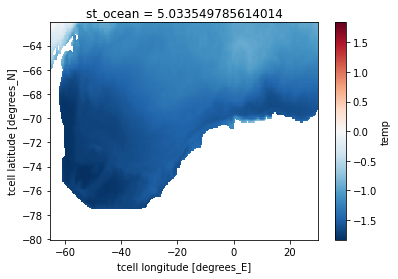

In [11]:
#testing to see if correctly sliced desired region
sst_mean = ds_wg.temp.isel(st_ocean=0).mean(dim='time')
sst_mean.plot()

## <span style='color:Red'> Bottom Potential Temperatures

In [12]:
#999 is ocean, 111 is land
hfacc = temp_mask.where(temp_mask == temp_mask.notnull(), 999).where(temp_mask < 999, 111)

In [13]:
#999 is ocean, 111 is land
depth_max = (ds_wg.st_ocean.where(hfacc == 999)).max(dim='st_ocean').load()

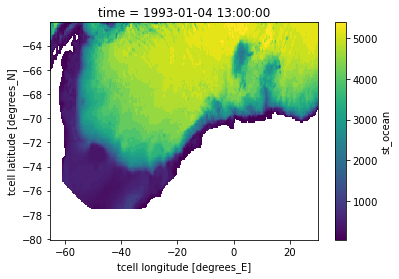

In [14]:
depth_max[0].plot()

In [28]:
hfacc_file = hfacc[0].to_dataset(name='hfacc')

In [29]:
hfacc_file

<xarray.Dataset>
Dimensions:   (st_ocean: 50, xt_ocean: 381, yt_ocean: 169)
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
    time      object 1993-01-04 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
Data variables:
    hfacc     (st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(50, 169, 381), meta=np.ndarray>

In [30]:
import json
with open('/home/jovyan/WMT-project/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcsfs_w_token = gcsfs.GCSFileSystem(token=token)

In [32]:
#uploading hfacc 
gcsmap_hfacc = gcsfs_w_token.get_mapper('pangeo-tmp/stb2145/SODA/datasets/hfacc.zarr')
hfacc_file.to_zarr(gcsmap_hfacc, mode='w')

In [ ]:
depth_surf.to_netcdf('depth_surf')

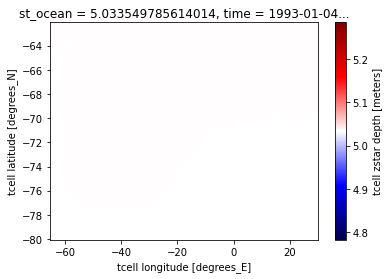

In [22]:
ds_wg.st_ocean.where(hfacc == 999)[0,0].min(dim='st_ocean').plot(cmap='seismic')

In [16]:
depth_surf = (ds_wg.st_ocean.where(hfacc == 999)).min(dim='st_ocean').load()

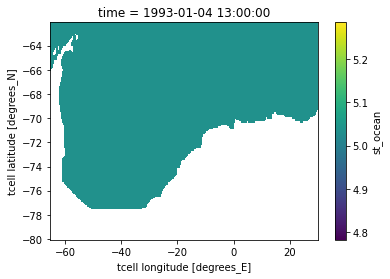

In [24]:
depth_surf[0].plot()

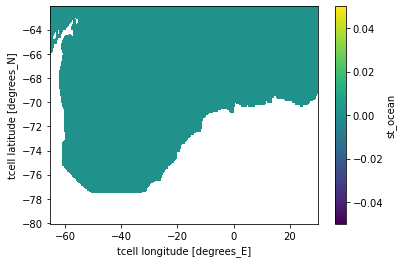

In [14]:
#depth doesn't change in time
depth_max.std(dim='time').plot()

In [15]:
depth_max = depth_max[0]

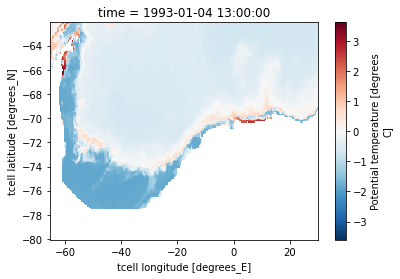

In [19]:
temp_mask[0].sel(st_ocean=depth_max, method='nearest').plot()

In [20]:
temp_mean = temp_mask.mean(dim='time').load()

In [21]:
bottom_temp = temp_mean.sel(st_ocean=depth_max, method='nearest')

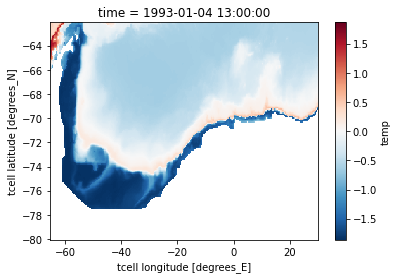

In [22]:
bottom_temp.plot()

In [23]:
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import regionmask
#import plot_proj_to_latlon_grid

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


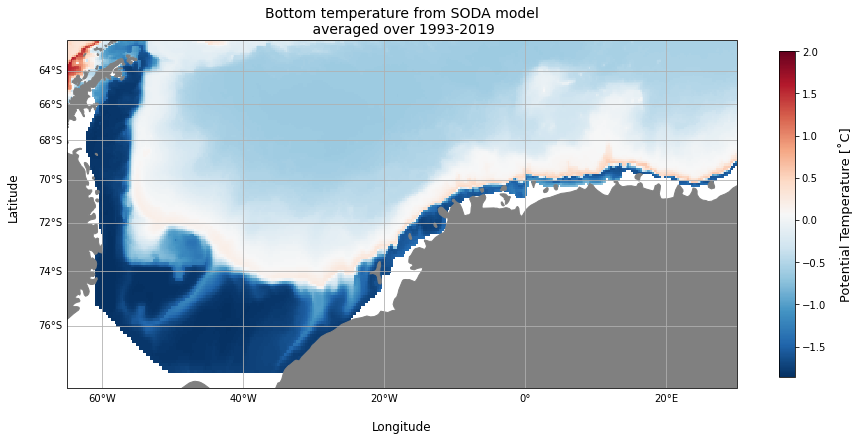

In [24]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(ds_wg.xt_ocean, ds_wg.yt_ocean, bottom_temp, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Bottom temperature from SODA model\n averaged over 1993-2019', fontsize=14);

## <span style='color:Red'> Bottom Temperature Standard Deviation (start)

In [25]:
temp_std = ds_wg.temp.std(dim='time').load()

In [26]:
bottom_temp_std = temp_std.sel(st_ocean=depth_max, method='nearest')

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


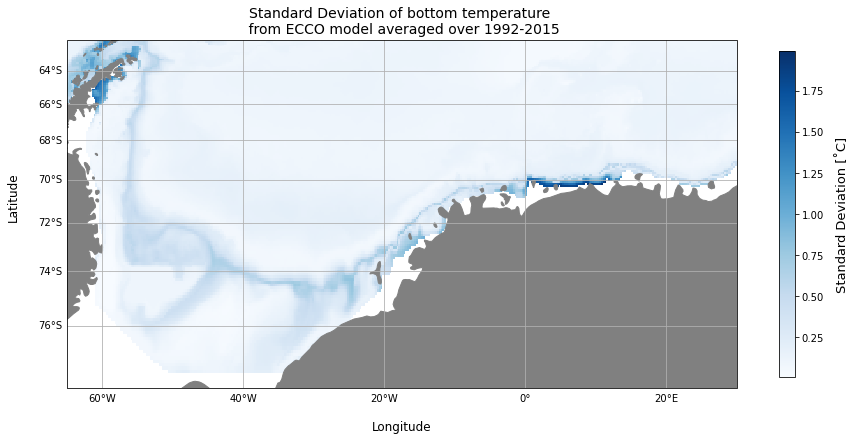

In [27]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(ds_wg.xt_ocean, ds_wg.yt_ocean, bottom_temp_std, transform=ccrs.PlateCarree(), cmap='Blues')
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Standard Deviation [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Standard Deviation of bottom temperature \n from SODA model averaged over 1993-2019', fontsize=14);

## <span style='color:Red'> Bottom Temperature Standard Deviation (end)

## <span style='color:Red'> Bottom Salinity

In [43]:
#999 is ocean, 111 is land
hfacc_salt = salt_mask.where(salt_mask == salt_mask.notnull(), 999).where(salt_mask < 999, 111)

In [44]:
#999 is ocean, 111 is land
depth_max_salt = (ds_wg.st_ocean.where(hfacc_salt == 999)).max(dim='st_ocean').load()

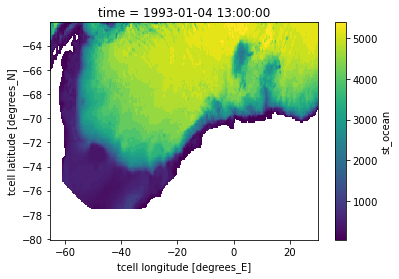

In [45]:
depth_max_salt[0].plot()

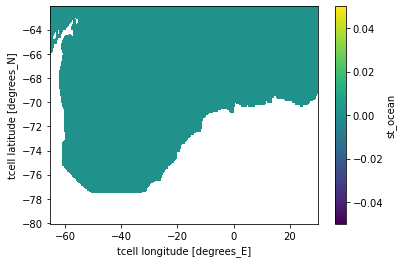

In [46]:
#depth doesn't change in time
depth_max_salt.std(dim='time').plot()

In [47]:
depth_max_salt = depth_max_salt[0]

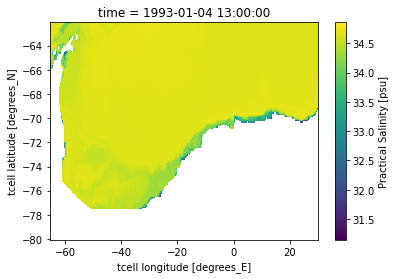

In [48]:
salt_mask[0].sel(st_ocean=depth_max_salt, method='nearest').plot()

In [49]:
salt_mean = salt_mask.mean(dim='time').load()

In [50]:
bottom_salt = salt_mean.sel(st_ocean=depth_max_salt, method='nearest')

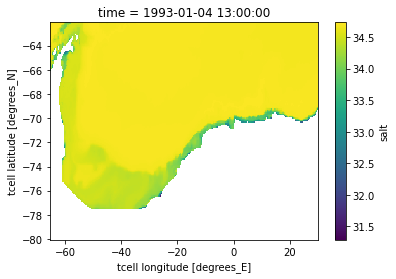

In [51]:
bottom_salt.plot()

In [52]:
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import regionmask
#import plot_proj_to_latlon_grid

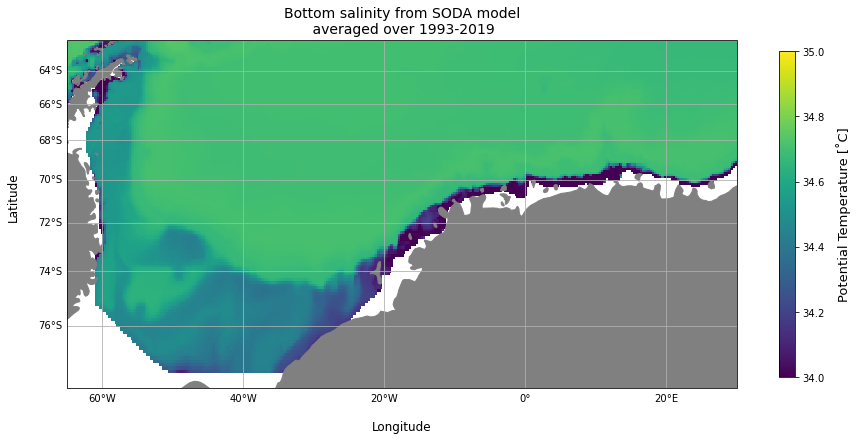

In [55]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(ds_wg.xt_ocean, ds_wg.yt_ocean, bottom_salt, transform=ccrs.PlateCarree(), cmap='viridis', vmin=34, vmax=35)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Bottom salinity from SODA model\n averaged over 1993-2019', fontsize=14);

## <span style='color:Red'> Bottom Temperature Standard Deviation (start)

In [56]:
salt_std = salt_mask.std(dim='time').load()

In [57]:
bottom_salt_std = salt_std.sel(st_ocean=depth_max_salt, method='nearest')

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


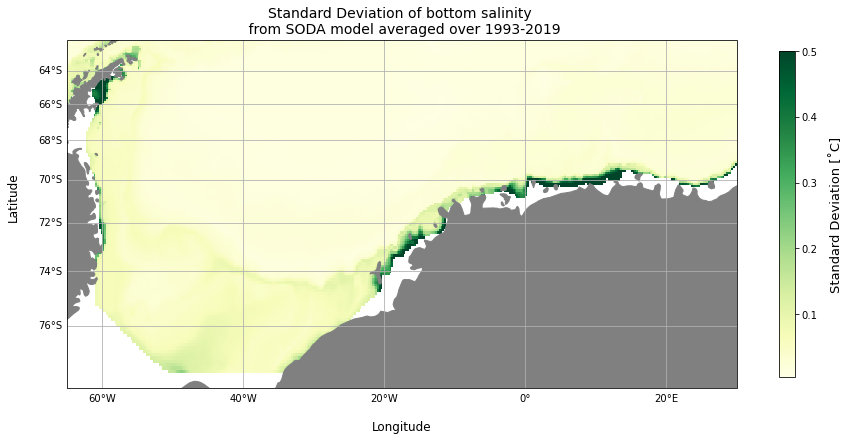

In [58]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(ds_wg.xt_ocean, ds_wg.yt_ocean, bottom_salt_std, transform=ccrs.PlateCarree(), cmap='YlGn', vmax=0.5)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Standard Deviation [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Standard Deviation of bottom salinity \n from SODA model averaged over 1993-2019', fontsize=14);

## <span style='color:Red'> Bottom Temperature Standard Deviation (end)